In [1]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree
from scipy.linalg import sqrtm

### Generate and Preprocess

The spatial correlation is attained by using Gaussian Processes with Matern correlation.

In [2]:
np.random.seed(15)
p = 3
n = 2000
# locations of observations (1x1 square domain)
s = np.random.rand(n,2)

In [3]:
def matern_correlation(distances, nu, length_scale):
    """
    Calculates the Matern correlation function.

    Args:
        distances (np.ndarray): A 1D array of distances between points.
        nu (float): The smoothness parameter of the Matern kernel.
                    Common values are 0.5, 1.5, 2.5, or infinity (for RBF kernel).
        length_scale (float): The characteristic length scale of the correlation.

    Returns:
        np.ndarray: A 1D array of Matern correlation values.
    """
    if nu == 0.5:
        # Exponential kernel (Matern with nu=0.5)
        return np.exp(-distances / length_scale)
    elif nu == 1.5:
        # Matern with nu=1.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(3) * scaled_dist) * np.exp(-np.sqrt(3) * scaled_dist)
    elif nu == 2.5:
        # Matern with nu=2.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(5) * scaled_dist + 5/3 * scaled_dist**2) * np.exp(-np.sqrt(5) * scaled_dist)
    elif np.isinf(nu):
        # Radial Basis Function (RBF) or Squared Exponential kernel (Matern with nu=infinity)
        return np.exp(-0.5 * (distances / length_scale)**2)
    else:
        # General Matern kernel (requires special functions from scipy.special)
        from scipy.special import kv, gamma
        scaled_dist = distances / length_scale
        # Handle the case where scaled_dist is zero to avoid division by zero in kv
        # and ensure correlation is 1 at zero distance.
        correlation = np.zeros_like(scaled_dist)
        non_zero_indices = scaled_dist > 1e-10 # Small epsilon to avoid exact zero
        
        correlation[non_zero_indices] = (2**(1-nu) / gamma(nu)) * \
                                        (np.sqrt(2*nu) * scaled_dist[non_zero_indices])**nu * \
                                        kv(nu, np.sqrt(2*nu) * scaled_dist[non_zero_indices])
        correlation[~non_zero_indices] = 1.0 # Correlation is 1 at zero distance
        return correlation

In [4]:
# Calculate pairwise distances between points
distances = pdist(s, 'euclidean') # Calculates distances in a condensed form
D = squareform(distances) # Converts to a square matrix

K1 = matern_correlation(D, 6, 1.2)
K2 = matern_correlation(D, 1, 1.5)
K3 = matern_correlation(D, 0.25, 1)
z = np.stack([
    np.random.multivariate_normal(np.zeros(n), K1),
    np.random.multivariate_normal(np.zeros(n), K2),
    np.random.multivariate_normal(np.zeros(n), K3)])

In [5]:
# mixing matrix
O = np.random.normal(size=(p,p))
x = O @ z

In [6]:
O

array([[-0.44763045,  0.96467246, -1.85360558],
       [ 0.04094633, -0.79126704,  1.36363663],
       [-0.2680828 ,  0.64470477,  0.25599788]])

In [7]:
np.savetxt('mixture.csv', x.T, delimiter=',')
np.savetxt('coords.csv', s, delimiter=',') 

In [8]:
def whiten(x):
    # center the data:
    x = x - x.mean(axis=1)[:, np.newaxis]
    # calculate the inverse squareroot of the covariance to whiten with
    S = x @ x.T / (x.shape[1] - 1)
    L_s, Q_s = np.linalg.eigh(S)
    W = Q_s @ np.diag(1 / (L_s)**0.5) @ Q_s.T
    return W @ x, W, Q_s @ np.diag((L_s)**0.5) @ Q_s.T

In [9]:
xt, W, W_inv = whiten(x)

In [10]:
# xt is whitened
np.cov(xt)

array([[ 1.00000000e+00,  2.18503443e-14, -2.42282988e-15],
       [ 2.18503443e-14,  1.00000000e+00, -4.89631125e-15],
       [-2.42282988e-15, -4.89631125e-15,  1.00000000e+00]])

### Join Diagonalize Local Covariance Matrices

Using SOBIsym optimizaiton (projected gradient descent)

In [11]:
def calculate_local_covariance(points, radius, variables):
    """
    Calculates the covariance matrix for points within a certain radius for each point.

    Args:
        points (np.ndarray): A NumPy array of shape (N, D) where N is the number of
                             points and D is the dimension (e.g., 3 for 3D points).
        radius (float): The radius within which to search for neighbors.
        variables (np.ndarray): a NumPy array of shape (N, P) where P is the dimension
                            of the variables

    Returns:
        np.ndarray: PxP matrix of the covariance
    """
    # Build a KD-Tree for efficient spatial searching
    tree = KDTree(points)
    
    # List to store the covariance matrix for each point
    covariance_matrix = np.zeros((variables.shape[1], variables.shape[1]))
    
    # Iterate over each point
    for i, query_point in enumerate(points):
        # Find indices of points within the specified radius
        neighbor_indices = tree.query_ball_point(query_point, radius)
        #print(query_point, neighbor_indices)
        # Select the neighboring points
        neighbors = variables[neighbor_indices]
        
        covariance_matrix += np.einsum('j, ik -> jk', variables[i], neighbors)
            
    return covariance_matrix / variables.shape[0]

In [14]:
# calculate local covariance matrices
M30 = calculate_local_covariance(s, 0.3, xt.T)
M10 = calculate_local_covariance(s, 0.1, xt.T)
M05 = calculate_local_covariance(s, 0.05, xt.T)
M01 = calculate_local_covariance(s, 0.01, xt.T)
M = np.stack((M30, M10, M05, M01), axis=1)

In [13]:
def H(g, S):
    # shape of S (p,k,p)
    return np.tensordot(g, S, axes=([0],[0])) @ g @ (S @ g).T

G = np.eye(p)
for i in range(5000):
    # gradient descent on each column
    for j in range(p):
        G[j,:] = H(G[j,:], M)
    # orthogonalize
    U, Sigma, V = np.linalg.svd(G)
    G = U @ V.T

In [15]:
# off-diagonals are minimized
G @ M30 @ G.T, G @ M10 @ G.T, G @ M05 @ G.T, G @ M01 @ G.T

(array([[177.22715927,  -0.68102163,  36.33331562],
        [ -0.68102163,  39.99482874,   7.03875139],
        [ 36.33331562,   7.03875139, 302.45881097]]),
 array([[45.15844732,  0.99554532,  2.17175619],
        [ 0.99554532, 21.63030506,  0.58256515],
        [ 2.17175619,  0.58256515, 53.41464236]]),
 array([[ 1.41384822e+01, -1.06299029e-02,  2.39580383e-01],
        [-1.06299029e-02,  8.58451166e+00,  1.58311270e-01],
        [ 2.39580383e-01,  1.58311270e-01,  1.52251475e+01]]),
 array([[1.59337897, 0.02119481, 0.02848237],
        [0.02119481, 1.50244029, 0.02917388],
        [0.02848237, 0.02917388, 1.64550362]]))

In [16]:
# Show that the optimization is affine invariant
# calculate local covariance matrices
M30_ = calculate_local_covariance(s, 0.3, x.T)
M10_ = calculate_local_covariance(s, 0.1, x.T)
M05_ = calculate_local_covariance(s, 0.05, x.T)
M01_ = calculate_local_covariance(s, 0.01, x.T)

In [18]:
G @ W  @ M30_ @ W @ G.T, G @ W @ M10_ @ W @ G.T, G @ W @ M05_ @ W @ G.T, G @ W @ M01_ @ W @ G.T

(array([[ 3081.28516367, -1012.62423752,  3556.69368928],
        [-1012.62423752,   390.70020197, -1215.68986861],
        [ 3556.69368928, -1215.68986861,  4561.68106783]]),
 array([[ 428.64242204, -138.58779427,  474.12827771],
        [-138.58779427,   72.39739206, -171.06840422],
        [ 474.12827771, -171.06840422,  633.79167696]]),
 array([[117.07019526, -38.07388689, 128.5808597 ],
        [-38.07388689,  22.65803242, -47.29286366],
        [128.5808597 , -47.29286366, 175.21292355]]),
 array([[11.88350678, -3.80881442, 12.99916233],
        [-3.80881442,  2.92794009, -4.79844421],
        [12.99916233, -4.79844421, 17.99475879]]))

In [19]:
# G is orthogonal
G @ G.T

array([[ 1.00000000e+00,  2.72749672e-17, -1.75558634e-16],
       [ 2.72749672e-17,  1.00000000e+00, -1.13970617e-16],
       [-1.75558634e-16, -1.13970617e-16,  1.00000000e+00]])

### Examine at Performance

In [20]:
from scipy.optimize import linear_sum_assignment

def MDI(G):
    Gt = G**2 / (np.linalg.norm(G, axis=1)**2)[:, np.newaxis]
    cost = np.ones_like(Gt) - 2*Gt - (Gt**2).sum(axis=1)[:, np.newaxis]
    row_ind, col_ind = linear_sum_assignment(cost, maximize=False)
    perm = np.argsort(col_ind)
    return (G.shape[0] - (Gt[row_ind, col_ind]).sum())**0.5 / (G.shape[0] - 1)**0.5

In [21]:
MDI(G @ W @ O)

np.float64(0.5568105252362378)

In [22]:
(G @ W) @ O

array([[ 6.10633865e-01,  4.46977419e+00,  2.74305404e-03],
       [ 1.58236762e+00,  3.37795832e-01, -1.77702806e+00],
       [-2.53622658e+00, -1.05508941e+00, -9.20461837e-02]])

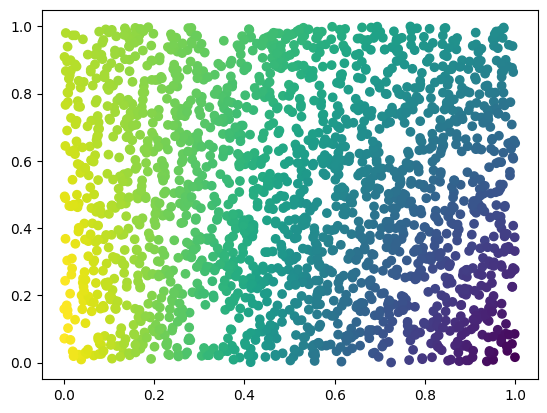

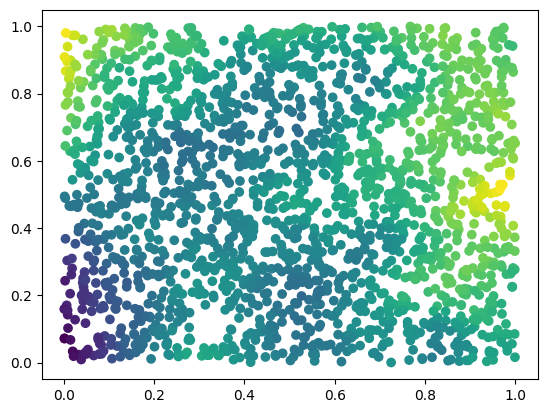

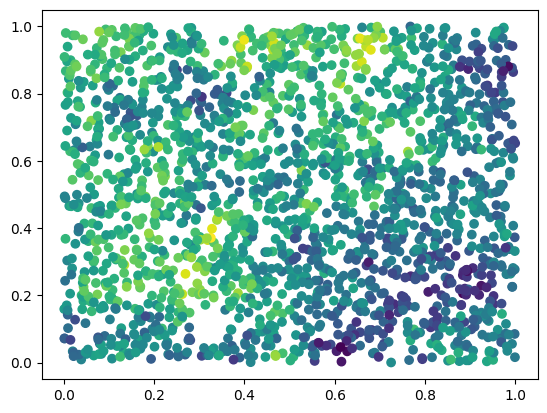

In [23]:
import matplotlib.pyplot as plt
plt.scatter(s.T[0], s.T[1], c = z[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[2])
plt.show()

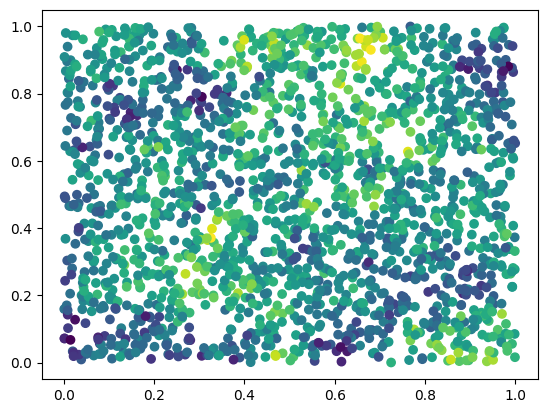

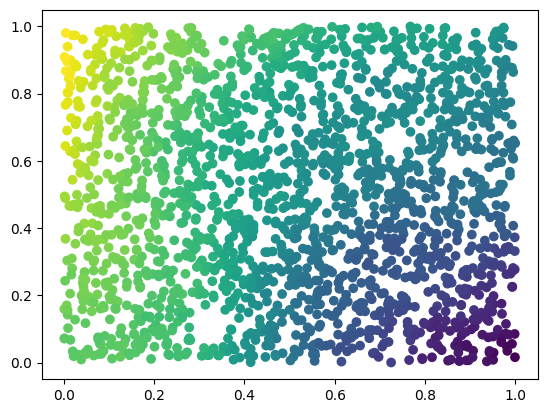

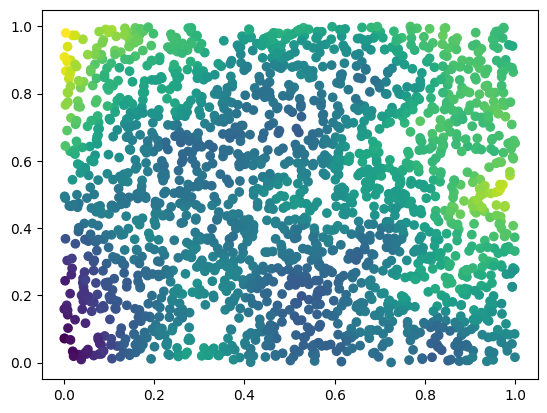

In [26]:
zt = G @ W @ x
plt.scatter(s.T[0], s.T[1], c = -1*zt[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = -1*zt[2])
plt.show()
plt.scatter(s.T[0], s.T[1], c = zt[0])
plt.show()

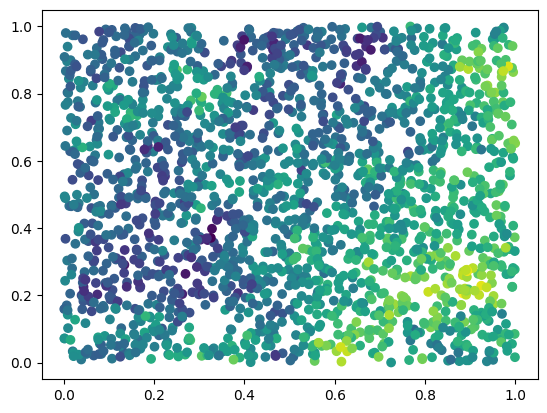

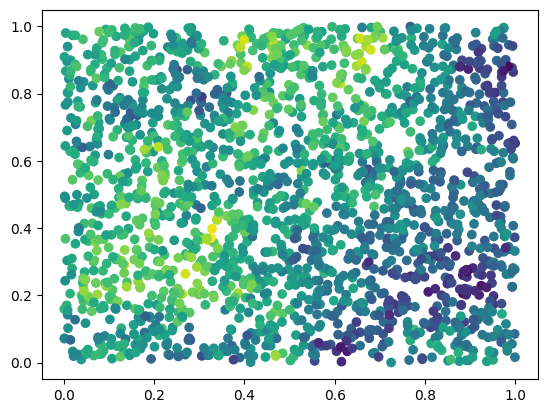

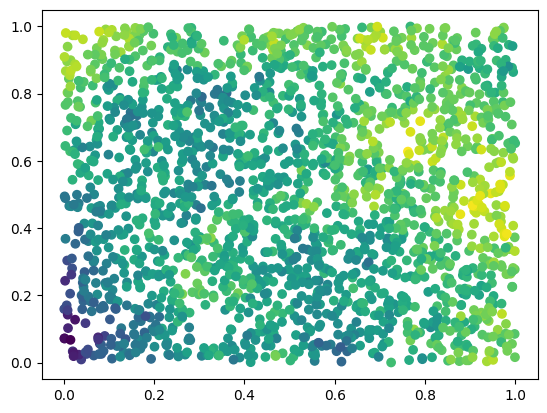

In [25]:
plt.scatter(s.T[0], s.T[1], c = x[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[2])
plt.show()